# Sphericity & Solidity

In this notebook you will learn how to calculate two common 3D shape descriptors for assessing how similar an object is to a perfect sphere. You will also compare object volume measurements from an image and its corresponding mesh representation.

Please download the required file for the variable `binary_gastruloid` from this link and add it to your data folder for this session:

<https://drive.google.com/file/d/1zywDJeNinfoJC49qFuskqxQ4HGniGSGK/view?usp=sharing>

You should not need a password. You will need to have [napari-process-points-and-surfaces](https://www.napari-hub.org/plugins/napari-process-points-and-surfaces) and the [vedo library](https://vedo.embl.es/) installed. They should already be part of your `devbio-napari-env`. If they are not, you can add them using `mamba install napari-process-points-and-surfaces` and `mamba install vedo`

The data used in this notebook is derived from [AV Luque and JV Veenvliet (2023)](https://zenodo.org/record/7603081) licensed [CC-BY](https://creativecommons.org/licenses/by/4.0/legalcode) and can be downloaded from here: https://zenodo.org/record/7603081. Compared to the original, the file used here is binary to reduce file size.

In [1]:
import napari
import napari_process_points_and_surfaces as nppas
import numpy as np
import vedo
from skimage.io import imread, imshow
from skimage.measure import regionprops

import matplotlib.pyplot as plt
%matplotlib inline

# Load Image Data

/Users/ryan/mambaforge/envs/devbio-napari-env/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


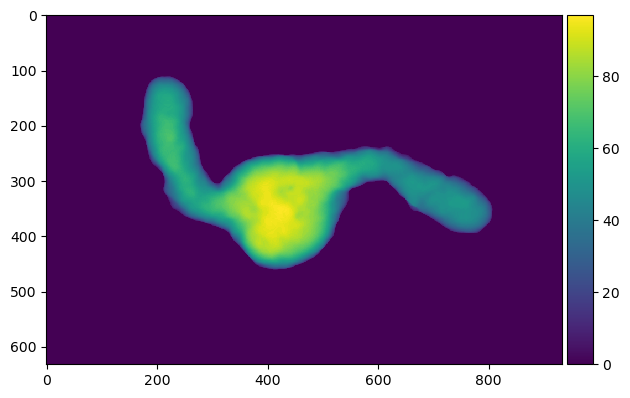

In [2]:
binary_gastruloid = imread('data/binary_gastruloid.tif')
imshow(binary_gastruloid.sum(axis = 0)) # sum projection visualization of binary 3d object

# Load Mesh Data

Use `vedo` which was introduced to you this morning to load a previously created mesh representation of the above gastruloid imaging dataset.

In [3]:
mesh_gastruloid = vedo.load('data/gastruloid.ply')

# Visualize Mesh

Use the `napari_process_points_and_surfaces` module to convert the vedo mesh into a `SurfaceTuple` that can be pushed to a napari viewer as a surface layer.

(array([[ 14.457619, 144.76721 , 213.91733 ],
        [ 14.386402, 149.81444 , 216.4062  ],
        [ 14.615121, 150.11465 , 211.54437 ],
        ...,
        [111.80431 , 357.6435  , 415.73914 ],
        [111.70839 , 357.06052 , 429.60495 ],
        [112.188705, 351.27747 , 423.60077 ]], dtype=float32),
 array([[   0,    1,    2],
        [   0,    3,    1],
        [   4,    5,    6],
        ...,
        [3308, 3306, 3307],
        [3299, 3308, 3307],
        [3304, 3308, 3305]]))
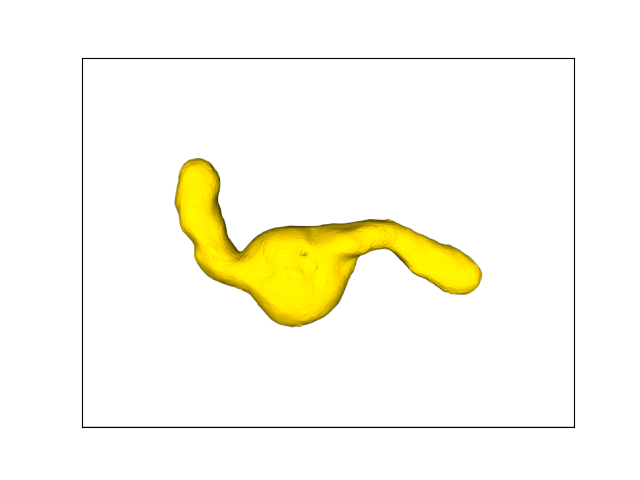

In [4]:
napari_mesh_gastruloid = nppas.to_napari_surface_data(mesh_gastruloid)
napari_mesh_gastruloid

## Push your image & your mesh to a napari viewer

Briefly have a look at the overlay of your image and surface layers in napari. It is best to use the 3d view so that you can spin the surface around and zoom in :)

In [5]:
viewer = napari.Viewer()

viewer.add_image(binary_gastruloid)
viewer.add_surface(napari_mesh_gastruloid)

<Surface layer 'napari_mesh_gastruloid' at 0x1b4354e20>

# Extract Mesh Volume & Surface Area

Here we take advantage of the many measurements that are immediately accessible from `vedo.Mesh`. For our downstream calculatin of sphericity, let's extract the mesh's volume and surface area.

In [6]:
mesh_volume = mesh_gastruloid.volume()
mesh_volume

4690998.704897018

In [7]:
mesh_surface_area = mesh_gastruloid.area()
mesh_surface_area

229569.5362677695

# Image Volume

Let's also calculate the volume of the binary gastruloid in image space (i.e., discretised space) by taking the count of nonzero voxels.

If you were working with a dataset with several objects, you could choose to apply `skiamge.measure.regionprops` and then retrive the equivalent values by using the key `area`. However, because this image only has one object, it is simple enough to use `numpy.sum`.

In [16]:
binary_volume = np.sum(binary_gastruloid)
binary_volume

4712181

# Calculate Sphericity

Here I have written a function to calculate sphericity. 

Sphericity is a very common metric for biological object shape assessment and is simply a specific ratio of volume and surface area. As you can see, the function takes two inputs: a volume measurement and a surface area measurement.

There are plenty of packages in python with functions to calculate sphericity; however, it is important to know (and understand) how they have defined the measurement. The one I have written here is probably the most common mathematical definiton. It has a range of (0,1) and is scalar (i.e., dimensionless). Some implementations you may find could have a different range depending on how the ratio is defined.

In [14]:
def sphericity(mesh_volume, mesh_surface_area):
    
    '''This definition of sphericity comes from a formula that  assumes your 
    object exists in continuous space.
    
    Parameters:
    -----------
    
    mesh_volume: integer or float value
    mesh_surface_area: integer or float value
    
    Returns:
    --------
    
    psi: a float value with range(0,1) reflecting the compactness of an object
    '''
    
    from numpy import pi
    
    numerator = (pi ** (1/3)) * ((6 * mesh_volume) ** (2/3))
    denominator = mesh_surface_area
    
    psi = numerator / denominator
    
    return psi

In [15]:
sphericity = sphericity(mesh_volume, mesh_surface_area)
sphericity

0.5903099128683961

# Convex Hull

Say you want to compare the sphericity measurement to another metric that should be correlated, but not identical. The example we will use here is solidity, which is the ratio of an object's volume to the volume of its convex hull. Therefore we must first create the convex hull of our mesh and then measure its volume.

(array([[ 14.457619, 144.76721 , 213.91733 ],
        [ 15.038892, 143.36473 , 207.20639 ],
        [ 15.429304, 136.4153  , 206.44937 ],
        ...,
        [111.480446, 305.31857 , 394.55396 ],
        [111.84808 , 344.62262 , 418.75836 ],
        [112.188705, 351.27747 , 423.60077 ]], dtype=float32),
 array([[  0,   1,   2],
        [  0,   2,   3],
        [  0,   3,   4],
        ...,
        [812, 807, 817],
        [787, 817, 777],
        [807, 777, 817]]))
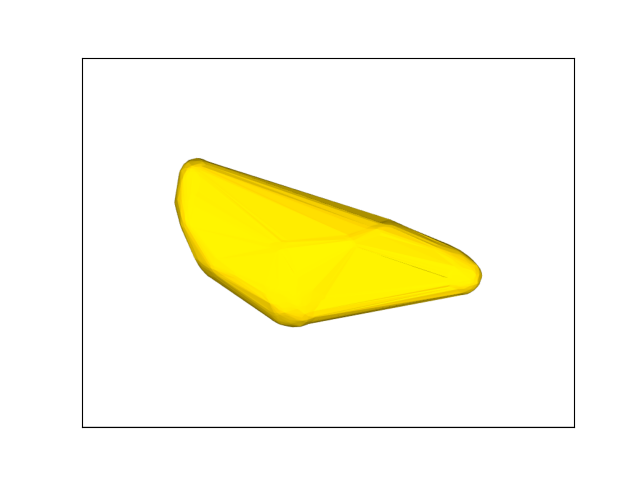

In [11]:
convex_hull_gastruloid = nppas.create_convex_hull_from_surface(napari_mesh_gastruloid)
convex_hull_gastruloid

In [12]:
convex_hull = nppas.to_vedo_mesh(convex_hull_gastruloid)
convex_hull_volume = convex_hull.volume()
convex_hull_volume

8379992.083160304

Now that we have the convex hull volume we can calculate the mesh's solidity.

In [13]:
gastruloid_solidity = mesh_volume / convex_hull_volume
gastruloid_solidity

0.5597855771634482

# Exercise

Calculate the sphericity of the gastruloid using `image_volume` instead of `mesh_volume` then find the percent difference between the two measurements. Is it statistically significant?

# Exercise

Apply `regionprops` from `skimage.measure` to `binary_gastruloid` and index the resultant dictionary to return the function's `solidity` measure. Is it identical (or statistically close enough) to what you computed above?